# Logistic Regression with Tensorflow 

Despite the name logistic regression, it is actually a probabilistic classification model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y} = exp(y) / (1 + exp(y)) = p 
$$

which produces p-values between 0 (as y approaches minus infinity $-\infty$) and 1 (as y approaches plus infinity $+\infty$). This now becomes a special kind of non-linear regression.

## Import Required Libraries 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Using the Iris Dataset 

This dataset was introduced by British Statistician and Biologist Ronald Fisher, it consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). In total it has 150 records under five attributes - petal length, petal width, sepal length, sepal width and species.

In [2]:
iris = load_iris()

iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=0)

The placeholders x and y allow us to create an algorithm in TensorFlow which accepts data and knows smoething about the shape of the data without knowing the amount of dtaa going in. Also, when we insert "batches" of data in training, we can easily adjust how many examples we train on in one step, at the train_test_split function. 

## Create Placeholders to hold Iris Data 

In [3]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This will be our correct answers matrix for 3 classes.

## Initialize TensorFlow Variables as Parameters 

In [4]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))

Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

However, for the sake of clarity, we can have it broken into its three main components: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 

In [6]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

# Training

## Cost Function 

We want to minimize the cost function in our model, which is the Squared Mean Error loss function. We will use batch gradient descent to minimize the cost funtion, which calculates the gradient from all data points in the data set. 

In [25]:
# Number of Epochs in our training
numEpochs = 1000

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0020,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [26]:
#Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

## Initialize TensorFlow Session 

In [27]:
# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

In [28]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [29]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.343434, cost 32.1479, change in cost 32.1479
step 10, training accuracy 0.686869, cost 26.1753, change in cost 5.97254
step 20, training accuracy 0.686869, cost 22.717, change in cost 3.45835
step 30, training accuracy 0.686869, cost 20.6499, change in cost 2.0671
step 40, training accuracy 0.686869, cost 19.3254, change in cost 1.3245
step 50, training accuracy 0.686869, cost 18.4108, change in cost 0.914618
step 60, training accuracy 0.686869, cost 17.7378, change in cost 0.672993
step 70, training accuracy 0.686869, cost 17.2166, change in cost 0.521162
step 80, training accuracy 0.707071, cost 16.7963, change in cost 0.42033
step 90, training accuracy 0.707071, cost 16.4461, change in cost 0.350149
step 100, training accuracy 0.707071, cost 16.1468, change in cost 0.299328
step 110, training accuracy 0.727273, cost 15.8855, change in cost 0.261254
step 120, training accuracy 0.727273, cost 15.6537, change in cost 0.231888
step 130, training accuracy 0.73

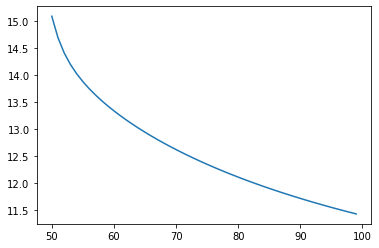

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()